<a href="https://colab.research.google.com/github/PanYuJ/Anomaly_detector_VAE/blob/main/anomaly_detection_patchcore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.Import module



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from glob import glob
import time
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.utils.random import sample_without_replacement

import torch
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchmetrics import PrecisionRecallCurve
from torchmetrics import AUROC
import torch.nn.functional as F
from torch import Tensor, nn

from anomalib.models.components import (
    FeatureExtractor,
    KCenterGreedy,
    )
from anomalib.models.patchcore.anomaly_map import AnomalyMapGenerator

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Mount goolge drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# 2.Loading data

In [ ]:
import os
import zipfile
import tarfile

screw_store = '/content/screw'
screw_source = '/content/gdrive/MyDrive/project/other/screw.zip'

def get_dataset(store_path, source):

  if not os.path.isdir(store_path):
    os.makedirs(store_path)

  tar = tarfile.open(source, 'r')
  tar.extractall(store_path)

get_dataset(screw_store, screw_source)

In [ ]:
def generate_df(working_dir):

  df = pd.DataFrame()
  paths = []
  labels = []
  mask_paths = []

  for root in working_dir:

    path = glob(os.path.join(root, "*"))
    paths += path

    if root.split(os.sep)[-1] == 'good':
      label = [0]*len(path)
      mask_path = ['']*len(path)

    else:
      # Get label
      label = [1]*len(path)

      # Get mask path
      sa, sb = os.sep + 'test' + os.sep, os.sep + 'ground_truth' + os.sep
      mask_path = []
      for ro in path:
        mask_pa = ro.replace(sa, sb, 1).split('.')[0] + '_mask.png'
        mask_path.append(mask_pa)

    labels += label
    mask_paths += mask_path

  df['image_paths'] = paths
  df['label'] = labels
  df['label'].apply(lambda x: str(x))
  df['mask_paths'] = mask_paths

  return df

# Get working directory
path_train = glob('/content/screw/screw/train/good')
path_test = glob('/content/screw/screw/test/*')

# Get dataframe
train_df = generate_df(path_train)
df = generate_df(path_test)

In [ ]:
df

,image_paths,label,mask_paths
0,/content/screw/screw/test/scratch_head/014.png,1,/content/screw/screw/ground_truth/scratch_head...
1,/content/screw/screw/test/scratch_head/013.png,1,/content/screw/screw/ground_truth/scratch_head...
2,/content/screw/screw/test/scratch_head/006.png,1,/content/screw/screw/ground_truth/scratch_head...
3,/content/screw/screw/test/scratch_head/004.png,1,/content/screw/screw/ground_truth/scratch_head...
4,/content/screw/screw/test/scratch_head/011.png,1,/content/screw/screw/ground_truth/scratch_head...
...,...,...,...
155,/content/screw/screw/test/scratch_neck/008.png,1,/content/screw/screw/ground_truth/scratch_neck...
156,/content/screw/screw/test/scratch_neck/022.png,1,/content/screw/screw/ground_truth/scratch_neck...
157,/content/screw/screw/test/scratch_neck/010.png,1,/content/screw/screw/ground_truth/scratch_neck...
158,/content/screw/screw/test/scratch_neck/015.png,1,/content/screw/screw/ground_truth/scratch_neck...


In [ ]:
def split_df(df, trsize):
  test_df, valid_df = train_test_split(df, test_size=trsize, shuffle=True, random_state=123, stratify=df['label'])

  print('test_df length: ', len(test_df), 'valid_df length: ', len(valid_df))
  test_df = test_df.reset_index(drop=True)
  valid_df = valid_df.reset_index(drop=True)
  return test_df, valid_df

test_df, valid_df  = split_df(df, 0.5)

test_df length:  80 valid_df length:  80


In [ ]:
test_df.head(10)

,image_paths,label,mask_paths
0,/content/screw/screw/test/thread_top/007.png,1,/content/screw/screw/ground_truth/thread_top/0...
1,/content/screw/screw/test/thread_side/016.png,1,/content/screw/screw/ground_truth/thread_side/...
2,/content/screw/screw/test/thread_top/009.png,1,/content/screw/screw/ground_truth/thread_top/0...
3,/content/screw/screw/test/manipulated_front/01...,1,/content/screw/screw/ground_truth/manipulated_...
4,/content/screw/screw/test/thread_side/012.png,1,/content/screw/screw/ground_truth/thread_side/...
5,/content/screw/screw/test/manipulated_front/00...,1,/content/screw/screw/ground_truth/manipulated_...
6,/content/screw/screw/test/scratch_head/006.png,1,/content/screw/screw/ground_truth/scratch_head...
7,/content/screw/screw/test/scratch_head/011.png,1,/content/screw/screw/ground_truth/scratch_head...
8,/content/screw/screw/test/good/007.png,0,
9,/content/screw/screw/test/good/036.png,0,


# 3.Data generator

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

class ObjectDataset(Dataset):
    def __init__(self, df, transform):
        self.transform = transform
        self.df = df

    def __getitem__(self, index):

        img = cv2.imread(self.df['image_paths'].iloc[index]).astype(np.float32)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.df['mask_paths'].iloc[index] != '':
          mask = cv2.imread(self.df['mask_paths'].iloc[index], cv2.IMREAD_GRAYSCALE).astype(np.float32)
          mask /= 255.0  # Convert mask pixel value 255.0 to 1.0
        else:
          mask = np.zeros(shape=(img.shape[0], img.shape[1])).astype(np.float32)


        label = self.df['label'].iloc[index]
        if self.transform is not None:
            augmented = self.transform(image=img, mask=mask)
            transformed_img = augmented['image']
            transformed_mask = augmented['mask']

        return transformed_img, label, transformed_mask

    def __len__(self):
        return len(self.df)

In [ ]:
image_size = (256,256)
crop_size = (224,224)
transform = A.Compose([
    A.Resize(height=image_size[0], width=image_size[1], always_apply=True),
    A.CenterCrop(height=crop_size[0], width=crop_size[1]),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

train_set = ObjectDataset(df=train_df, transform=transform)
vaild_set = ObjectDataset(df=valid_df, transform=transform)
test_set = ObjectDataset(df=test_df, transform=transform)

batch_size = 32
shuffle = False
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=shuffle, num_workers=2)
val_loader = DataLoader(dataset=vaild_set, batch_size=batch_size, shuffle=shuffle, num_workers=2)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=shuffle, num_workers=2)

#4.K Center greedy function

In [ ]:
class SparseRandomProjection:
    """Sparse Random Projection using PyTorch operations.

    Args:
        eps (float, optional): Minimum distortion rate parameter for calculating
            Johnson-Lindenstrauss minimum dimensions. Defaults to 0.1.
        random_state (int | None, optional): Uses the seed to set the random
            state for sample_without_replacement function. Defaults to None.
    """

    def __init__(self, eps: float = 0.1, random_state: int | None = None) -> None:
        self.n_components: int
        self.sparse_random_matrix: Tensor
        self.eps = eps
        self.random_state = random_state

    def _sparse_random_matrix(self, n_features: int):
        """

        Args:
            n_features (int): Dimentionality of the original source space

        Returns:
            Tensor: Sparse matrix of shape (n_components, n_features).
                The generated Gaussian random matrix is in CSR (compressed sparse row)
                format.
        """

        # Density 'auto'. Factorize density
        density = 1 / np.sqrt(n_features)

        if density == 1:
            # skip index generation if totally dense
            binomial = torch.distributions.Binomial(total_count=1, probs=0.5)
            components = binomial.sample((self.n_components, n_features)) * 2 - 1
            components = 1 / np.sqrt(self.n_components) * components

        else:
            # Sparse matrix is not being generated here as it is stored as dense anyways
            components = torch.zeros((self.n_components, n_features), dtype=torch.float64)
            for i in range(self.n_components):
                # find the indices of the non-zero components for row i
                nnz_idx = torch.distributions.Binomial(total_count=n_features, probs=density).sample()
                # get nnz_idx column indices
                # pylint: disable=not-callable
                c_idx = torch.tensor(
                    sample_without_replacement(
                        n_population=n_features, n_samples=nnz_idx, random_state=self.random_state
                    ),
                    dtype=torch.int64,
                )
                data = torch.distributions.Binomial(total_count=1, probs=0.5).sample(sample_shape=c_idx.size()) * 2 - 1
                # assign data to only those columns
                components[i, c_idx] = data.double()

            components *= np.sqrt(1 / density) / np.sqrt(self.n_components)

        return components

    def johnson_lindenstrauss_min_dim(self, n_samples: int, eps: float = 0.1):
        """Find a 'safe' number of components to randomly project to.

        Ref eqn 2.1 https://cseweb.ucsd.edu/~dasgupta/papers/jl.pdf

        Args:
            n_samples (int): Number of samples used to compute safe components
            eps (float, optional): Minimum distortion rate. Defaults to 0.1.
        """

        denominator = (eps**2 / 2) - (eps**3 / 3)
        return (4 * np.log(n_samples) / denominator).astype(np.int64)

    def fit(self, embedding: Tensor) -> SparseRandomProjection:
        """Generates sparse matrix from the embedding tensor.

        Args:
            embedding (Tensor): embedding tensor for generating embedding

        Returns:
            (SparseRandomProjection): Return self to be used as
            >>> generator = SparseRandomProjection()
            >>> generator = generator.fit()
        """
        n_samples, n_features = embedding.shape
        device = embedding.device

        self.n_components = self.johnson_lindenstrauss_min_dim(n_samples=n_samples, eps=self.eps)

        # Generate projection matrix
        # torch can't multiply directly on sparse matrix and moving sparse matrix to cuda throws error
        # (Could not run 'aten::empty_strided' with arguments from the 'SparseCsrCUDA' backend)
        # hence sparse matrix is stored as a dense matrix on the device
        self.sparse_random_matrix = self._sparse_random_matrix(n_features=n_features).to(device)

        return self

    def transform(self, embedding: Tensor) -> Tensor:
        """Project the data by using matrix product with the random matrix.

        Args:
            embedding (Tensor): Embedding of shape (n_samples, n_features)
                The input data to project into a smaller dimensional space

        Returns:
            projected_embedding (Tensor): Sparse matrix of shape
                (n_samples, n_components) Projected array.
        """
        if self.sparse_random_matrix is None:
            raise NotFittedError("`fit()` has not been called on SparseRandomProjection yet.")

        projected_embedding = embedding @ self.sparse_random_matrix.T.float()
        return projected_embedding

In [ ]:
class KCenterGreedy:
    """Implements k-center-greedy method.

    Args:
        embedding (Tensor): Embedding vector extracted from a CNN
        sampling_ratio (float): Ratio to choose coreset size from the embedding size.

    Example:
        >>> embedding.shape
        torch.Size([219520, 1536])
        >>> sampler = KCenterGreedy(embedding=embedding)
        >>> sampled_idxs = sampler.select_coreset_idxs()
        >>> coreset = embedding[sampled_idxs]
        >>> coreset.shape
        torch.Size([219, 1536])
    """

    def __init__(self, embedding: Tensor, sampling_ratio: float) -> None:
        self.embedding = embedding
        self.coreset_size = int(embedding.shape[0] * sampling_ratio)
        self.model = SparseRandomProjection(eps=0.9)

        self.features: Tensor
        self.min_distances: Tensor = None
        self.n_observations = self.embedding.shape[0]

    def reset_distances(self) -> None:
        """Reset minimum distances."""
        self.min_distances = None

    def update_distances(self, cluster_centers: list[int]) -> None:
        """Update min distances given cluster centers.

        Args:
            cluster_centers (list[int]): indices of cluster centers
        """

        if cluster_centers:
            centers = self.features[cluster_centers]

            distance = F.pairwise_distance(self.features, centers, p=2).reshape(-1, 1)

            if self.min_distances is None:
                self.min_distances = distance
            else:
                self.min_distances = torch.minimum(self.min_distances, distance)

    def get_new_idx(self) -> int:
        """Get index value of a sample.

        Based on minimum distance of the cluster

        Returns:
            int: Sample index
        """

        if isinstance(self.min_distances, Tensor):
            idx = int(torch.argmax(self.min_distances).item())
        else:
            raise ValueError(f"self.min_distances must be of type Tensor. Got {type(self.min_distances)}")

        return idx

    def select_coreset_idxs(self, selected_idxs: list[int] | None = None) -> list[int]:
        """Greedily form a coreset to minimize the maximum distance of a cluster.

        Args:
            selected_idxs: index of samples already selected. Defaults to an empty set.

        Returns:
          indices of samples selected to minimize distance to cluster centers
        """

        if selected_idxs is None:
            selected_idxs = []

        if self.embedding.ndim == 2:
            self.model.fit(self.embedding)
            self.features = self.model.transform(self.embedding)
            self.reset_distances()
        else:
            self.features = self.embedding.reshape(self.embedding.shape[0], -1)
            self.update_distances(cluster_centers=selected_idxs)

        selected_coreset_idxs: list[int] = []
        idx = int(torch.randint(high=self.n_observations, size=(1,)).item())
        for _ in range(self.coreset_size):
            self.update_distances(cluster_centers=[idx])
            idx = self.get_new_idx()
            if idx in selected_idxs:
                raise ValueError("New indices should not be in selected indices.")
            self.min_distances[idx] = 0
            selected_coreset_idxs.append(idx)

        return selected_coreset_idxs

    def sample_coreset(self, selected_idxs: list[int] | None = None) -> Tensor:
        """Select coreset from the embedding.

        Args:
            selected_idxs: index of samples already selected. Defaults to an empty set.

        Returns:
            Tensor: Output coreset

        """

        idxs = self.select_coreset_idxs(selected_idxs)
        coreset = self.embedding[idxs]

        return coreset

# 5.Anomaly Map Generator

In [ ]:
class AnomalyMapGenerator(nn.Module):
    """Generate Anomaly Heatmap."""

    def __init__(
        self,
        input_size: ListConfig | tuple,
        sigma: int = 4,
    ) -> None:
        super().__init__()
        self.input_size = input_size
        kernel_size = 2 * int(4.0 * sigma + 0.5) + 1
        self.blur = GaussianBlur2d(kernel_size=(kernel_size, kernel_size), sigma=(sigma, sigma), channels=1)

    def compute_anomaly_map(self, patch_scores: Tensor) -> Tensor:
        """Pixel Level Anomaly Heatmap.

        Args:
            patch_scores (Tensor): Patch-level anomaly scores

        Returns:
            Tensor: Map of the pixel-level anomaly scores
        """
        anomaly_map = F.interpolate(patch_scores, size=(self.input_size[0], self.input_size[1]))
        anomaly_map = self.blur(anomaly_map)

        return anomaly_map

    def forward(self, patch_scores: Tensor) -> Tensor:
        """Returns anomaly_map and anomaly_score.

        Args:
            patch_scores (Tensor): Patch-level anomaly scores

        Example
        >>> anomaly_map_generator = AnomalyMapGenerator(input_size=input_size)
        >>> map = anomaly_map_generator(patch_scores=patch_scores)

        Returns:
            Tensor: anomaly_map
        """
        anomaly_map = self.compute_anomaly_map(patch_scores)
        return anomaly_map

In [ ]:
class PatchcoreModel(nn.Module):
    """Patchcore Module."""

    def __init__(
        self,
        input_size: tuple[int, int],
        layers: list[str],
        backbone: str = "wide_resnet50_2",
        pre_trained: bool = True,
        num_neighbors: int = 9,
        load_bank: str = None
    ) -> None:
        super().__init__()

        self.backbone = backbone
        self.layers = layers
        self.input_size = input_size
        self.num_neighbors = num_neighbors

        self.feature_extractor = FeatureExtractor(backbone=self.backbone, pre_trained=pre_trained, layers=self.layers)
        self.feature_pooler = torch.nn.AvgPool2d(3, 1, 1)
        self.anomaly_map_generator = AnomalyMapGenerator(input_size=input_size)

        self.register_buffer("memory_bank", Tensor())

        self.load_bank = load_bank

        if self.load_bank is not None:
          self.memory_bank = torch.load(load_bank)
        else:
          self.memory_bank: Tensor

    def forward(self, input_tensor: Tensor) -> Tensor | tuple[Tensor, Tensor]:
        """Return Embedding during training, or a tuple of anomaly map and anomaly score during testing.

        Steps performed:
        1. Get features from a CNN.
        2. Generate embedding based on the features.
        3. Compute anomaly map in test mode.

        Args:
            input_tensor (Tensor): Input tensor

        Returns:
            Tensor | tuple[Tensor, Tensor]: Embedding for training,
                anomaly map and anomaly score for testing.
        """
        with torch.no_grad():
          features = self.feature_extractor(input_tensor)

        features = {layer: self.feature_pooler(feature) for layer, feature in features.items()}
        embedding = self.generate_embedding(features)

        batch_size, _, width, height = embedding.shape
        embedding = self.reshape_embedding(embedding)

        if self.training:
            output = embedding
        else:
            # apply nearest neighbor search
            patch_scores, locations = self.nearest_neighbors(embedding=embedding, n_neighbors=1)
            # reshape to batch dimension
            patch_scores = patch_scores.reshape((batch_size, -1))
            locations = locations.reshape((batch_size, -1))
            # compute anomaly score
            anomaly_score = self.compute_anomaly_score(patch_scores, locations, embedding)
            # reshape to w, h
            patch_scores = patch_scores.reshape((batch_size, 1, width, height))
            # get anomaly map
            anomaly_map = self.anomaly_map_generator(patch_scores)

            output = (anomaly_map, anomaly_score)

        return output

    def generate_embedding(self, features: dict[str, Tensor]) -> Tensor:
        """Generate embedding from hierarchical feature map.

        Args:
            features: Hierarchical feature map from a CNN (ResNet18 or WideResnet)
            features: dict[str:Tensor]:

        Returns:
            Embedding vector
        """

        embeddings = features[self.layers[0]]
        for layer in self.layers[1:]:
            layer_embedding = features[layer]
            layer_embedding = F.interpolate(layer_embedding, size=embeddings.shape[-2:], mode="nearest")
            embeddings = torch.cat((embeddings, layer_embedding), 1)

        return embeddings

    @staticmethod
    def reshape_embedding(embedding: Tensor) -> Tensor:
        """Reshape Embedding.

        Reshapes Embedding to the following format:
        [Batch, Embedding, Patch, Patch] to [Batch*Patch*Patch, Embedding]

        Args:
            embedding (Tensor): Embedding tensor extracted from CNN features.

        Returns:
            Tensor: Reshaped embedding tensor.
        """
        embedding_size = embedding.size(1)
        embedding = embedding.permute(0, 2, 3, 1).reshape(-1, embedding_size)
        return embedding

    def subsample_embedding(self, embedding: Tensor, sampling_ratio: float) -> None:
        """Subsample embedding based on coreset sampling and store to memory.

        Args:
            embedding (np.ndarray): Embedding tensor from the CNN
            sampling_ratio (float): Coreset sampling ratio
        """

        # Coreset Subsampling
        sampler = KCenterGreedy(embedding=embedding, sampling_ratio=sampling_ratio)
        coreset = sampler.sample_coreset()
        self.memory_bank = coreset

        return self.memory_bank

    def nearest_neighbors(self, embedding: Tensor, n_neighbors: int) -> tuple[Tensor, Tensor]:
        """Nearest Neighbours using brute force method and euclidean norm.

        Args:
            embedding (Tensor): Features to compare the distance with the memory bank.
            n_neighbors (int): Number of neighbors to look at

        Returns:
            Tensor: Patch scores.
            Tensor: Locations of the nearest neighbor(s).
        """
        distances = torch.cdist(embedding, self.memory_bank, p=2.0)  # euclidean norm
        if n_neighbors == 1:
            # when n_neighbors is 1, speed up computation by using min instead of topk
            patch_scores, locations = distances.min(1)
        else:
            patch_scores, locations = distances.topk(k=n_neighbors, largest=False, dim=1)
        return patch_scores, locations

    def compute_anomaly_score(self, patch_scores: Tensor, locations: Tensor, embedding: Tensor) -> Tensor:
        """Compute Image-Level Anomaly Score.

        Args:
            patch_scores (Tensor): Patch-level anomaly scores
            locations: Memory bank locations of the nearest neighbor for each patch location
            embedding: The feature embeddings that generated the patch scores
        Returns:
            Tensor: Image-level anomaly scores
        """

        # Don't need to compute weights if num_neighbors is 1
        if self.num_neighbors == 1:
            return patch_scores.amax(1)
        batch_size, num_patches = patch_scores.shape
        # 1. Find the patch with the largest distance to it's nearest neighbor in each image
        max_patches = torch.argmax(patch_scores, dim=1)  # indices of m^test,* in the paper
        # m^test,* in the paper
        max_patches_features = embedding.reshape(batch_size, num_patches, -1)[torch.arange(batch_size), max_patches]
        # 2. Find the distance of the patch to it's nearest neighbor, and the location of the nn in the membank
        score = patch_scores[torch.arange(batch_size), max_patches]  # s^* in the paper
        nn_index = locations[torch.arange(batch_size), max_patches]  # indices of m^* in the paper
        # 3. Find the support samples of the nearest neighbor in the membank
        nn_sample = self.memory_bank[nn_index, :]  # m^* in the paper
        # indices of N_b(m^*) in the paper
        _, support_samples = self.nearest_neighbors(nn_sample, n_neighbors=self.num_neighbors)
        # 4. Find the distance of the patch features to each of the support samples
        distances = torch.cdist(max_patches_features.unsqueeze(1), self.memory_bank[support_samples], p=2.0)
        # 5. Apply softmax to find the weights
        weights = (1 - F.softmax(distances.squeeze(1), 1))[..., 0]
        # 6. Apply the weight factor to the score
        score = weights * score  # s in the paper
        return score

In [ ]:
def anomaly_map_mask_to_color_map(anomaly_map: np.ndarray, mask: np.ndarray, normalize: bool = True) -> np.ndarray:
    """Compute anomaly color heatmap.

    Args:
        anomaly_map (np.ndarray): Final anomaly map computed by the distance metric.
        mask (np.ndarray): Input mask (ground truth)
        normalize (bool, optional): Bool to normalize the anomaly map prior to applying
            the color map. Defaults to True.

    Returns:
        np.ndarray: [description]
    """
    if normalize:
      anomaly_map = (anomaly_map - anomaly_map.min()) / (np.ptp(anomaly_map) + 1e-10)

    anomaly_map = anomaly_map * 255
    anomaly_map = anomaly_map.astype(np.uint8)
    anomaly_map = cv2.applyColorMap(anomaly_map.squeeze(), cv2.COLORMAP_JET)
    anomaly_map = cv2.cvtColor(anomaly_map, cv2.COLOR_BGR2RGB)


    mask = mask * 255
    mask = mask.astype(np.uint8)
    mask = cv2.applyColorMap(mask.squeeze(), cv2.COLORMAP_JET)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    return anomaly_map, mask

def convert_original_image(image):

  mean = np.array([0.485, 0.456, 0.406]).reshape((1,1,3))
  std = np.array([0.229, 0.224, 0.225]).reshape((1,1,3))
  max_pixel_value = 255

  image = image*(std * max_pixel_value) + (mean * max_pixel_value)

  return image

def superimpose_anomaly_map_mask(anomaly_map: np.ndarray, image: np.ndarray, mask: np.ndarray, alpha: float = 0.4, gamma: int = 0, normalize: bool = True) -> np.ndarray:
    """Superimpose anomaly map on top of in the input image.

    Args:
        anomaly_map (np.ndarray): Anomaly map
        image (np.ndarray): Input image
        mask (np.ndarray): Input mask
        alpha (float, optional): Weight to overlay anomaly map
            on the input image. Defaults to 0.4.
        gamma (int, optional): Value to add to the blended image
            to smooth the processing. Defaults to 0. Overall,
            the formula to compute the blended image is
            I' = (alpha*I1 + (1-alpha)*I2) + gamma
        normalize: whether or not the anomaly maps should
            be normalized to image min-max


    Returns:
        np.ndarray: Image with anomaly map superimposed on top of it.
    """
    anomaly_map = anomaly_map.squeeze()
    anomaly_map = cv2.cvtColor(anomaly_map, cv2.COLOR_BGR2RGB)
    anomaly_map, mask = anomaly_map_mask_to_color_map(anomaly_map, mask.squeeze(), normalize=normalize)

    image = image.squeeze()
    image = convert_original_image(image)
    image = image.astype(np.uint8)

    superimposed_map = cv2.addWeighted(anomaly_map, alpha, image, (1 - alpha), gamma)
    superimposed_mask = cv2.addWeighted(mask, alpha, image, (1 - alpha), gamma)
    return superimposed_map, superimposed_mask, image

In [ ]:
def f1_score(y_pred, y_true):

  if isinstance(y_true, Tensor):
    y_true = y_true.numpy()

  TP = np.sum(y_pred * y_true)
  FP = np.sum((1-y_true) * y_pred)
  FN = np.sum(y_true * (1-y_pred))

  precise = TP / (TP + FP)
  recall = TP / (TP + FN)
  f1 = 2*(precise * recall) / (precise + recall)
  f1 = np.mean(f1)
  return f1

In [ ]:
from torchmetrics.functional import auc
from torchmetrics import ROC

class patcthcore_detector(nn.Module):
  def __init__(self,
          input_size: tuple[int, int],
          backbone: str,
          layers: list[str],
          load_bank: str = None,
          pre_trained: bool = True,
          num_neighbors: int = 9,
               ):

    super().__init__()
    self.input_size = input_size
    self.backbone = backbone
    self.pre_trained = pre_trained
    self.layers = layers
    self.num_neighbors = num_neighbors
    self.pr_curve = PrecisionRecallCurve()
    self.roc = ROC()
    self.load_bank = load_bank
    self.model = PatchcoreModel(
                    input_size=self.input_size,
                    backbone=self.backbone,
                    pre_trained=self.pre_trained,
                    layers=self.layers,
                    num_neighbors=self.num_neighbors,
                    load_bank = self.load_bank
                    )

    self.model = self.model.to(device)
    self.threshold = None
    self.embeddings: list[Tensor] = []

  def training_step(self, dataloader, coreset_sampling_ratio=0.01, save_bank: str=None):

    self.model.feature_extractor.eval()

    if self.load_bank is not None:
      pass

    else:
      for step, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        img = batch[0].to(device)
        embedding = self.model(img)
        self.embeddings.append(embedding)
      self.embeddings = torch.vstack(self.embeddings)
      memory_bank = self.model.subsample_embedding(self.embeddings, sampling_ratio = coreset_sampling_ratio)

      if save_bank is not None:
        torch.save(memory_bank, save_bank)

  def validation_step(self, dataloader, task='val'):

    self.model.eval()

    anomaly_maps = []
    anomaly_scores = []
    labels = []
    images = []
    masks = []

    for step, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
      img = batch[0].to(device)
      label = batch[1]
      mask = batch[2]

      anomaly_map, anomaly_score = self.model(img)
      anomaly_map = torch.log(anomaly_map)
      anomaly_score = torch.log(anomaly_score)

      anomaly_maps.append(anomaly_map)
      anomaly_scores.append(anomaly_score)
      labels.append(label)
      images.append(img)
      masks.append(mask)

    anomaly_scores = torch.cat(anomaly_scores, dim=0).cpu()
    anomaly_maps = torch.cat(anomaly_maps, dim=0).cpu()

    images = torch.cat(images, dim=0).cpu()
    labels = torch.cat(labels)
    masks = torch.cat(masks)

    if task =='val':
      # Get threshold (score < threshold => normal)
      precision, recall, thresholds = self.pr_curve(anomaly_scores, labels)
      f1 = (2 * precision * recall) / (precision + recall + 1e-10)
      self.value = thresholds[torch.argmax(f1)]
      return anomaly_maps, anomaly_scores, self.value

    if task == 'test':
      anomaly_scores = np.where(anomaly_scores<self.value, 0, 1)

      f1 = f1_score(anomaly_scores, labels)

      fpr, tpr, thresholds = self.roc(anomaly_maps.squeeze(1).flatten(), masks.flatten())
      auc_score = auc(fpr, tpr, reorder=True)

      anomaly_maps = np.where(anomaly_maps<self.value, 0, anomaly_maps)
      anomaly_maps = anomaly_maps.squeeze()

      labels = labels.numpy()
      images = images.permute(0,2,3,1).numpy()
      masks = masks.numpy()
      auc_score = auc_score.numpy()

      return anomaly_maps, anomaly_scores, labels, images, masks, f1, auc_score

  def visualize_reslut(self, anomaly_maps, images, masks, labels):

    fig, axs = plt.subplots(2,3)
    for ax in axs.ravel():
      ax.set_axis_off()
    for i in [0,1]:
      indexes = np.where(labels==i)[0]
      index = np.random.choice(indexes, 1)

      # Superimpose anomaly_map and mask on image
      superimposed_map, superimposed_mask, image = superimpose_anomaly_map_mask(anomaly_maps[index], images[index], masks[index])

      if i==0:
        axs[i,0].set_title('Normal')
        axs[i,0].imshow(image)
        axs[i,1].set_title('Ground Truth')
        axs[i,1].imshow(superimposed_mask)
        axs[i,2].set_title('Predict Heat Map')
        axs[i,2].imshow(superimposed_map)

      if i==1:
        # Superimpose anomaly_map and mask on image
        superimposed_map, superimposed_mask, image = superimpose_anomaly_map_mask(anomaly_maps[index], images[index], masks[index])

        axs[i,0].set_title('Abnormal')
        axs[i,0].imshow(image)
        axs[i,1].set_title('Ground Truth')
        axs[i,1].imshow(superimposed_mask)
        axs[i,2].set_title('Predict Heat Map')
        axs[i,2].imshow(superimposed_map)
    plt.tight_layout
    plt.show()

In [ ]:
# build detector
patchcore = patcthcore_detector(input_size = [224,224],
                  layers = ["layer2", "layer3"],
                  backbone = "wide_resnet50_2",
                  pre_trained = True,
                  num_neighbors = 5,
                  load_bank = '/content/gdrive/MyDrive/project/other/patchcore/embedding_screw_n5_s224.pt'
                                )

# embedding training data into model and get embedding vector
embeddings = patchcore.training_step(train_loader, coreset_sampling_ratio=0.1, save_bank=None)

# Get
_, _, threshold = patchcore.validation_step(val_loader, task='val')

anomaly_maps, anomaly_scores, labels, images, masks, f1, auc_score = patchcore.validation_step(test_loader, task='test')

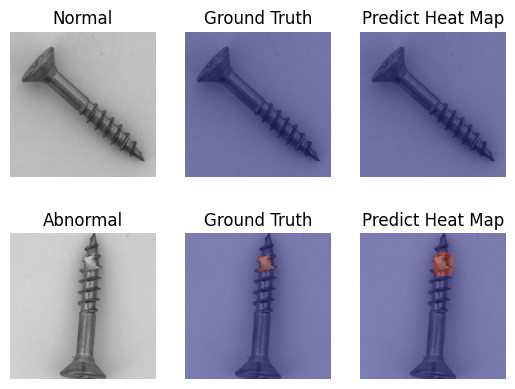

In [ ]:
# Show prdection
patchcore.visualize_reslut(anomaly_maps, images, masks, labels)